In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import patsy
from plotnine import *
from scipy.stats import ttest_ind

In [2]:
analysis_df = pd.read_csv('../20_intermediate/confounding_factors.csv')

# Deleting two extra columns
del analysis_df['Unnamed: 0']
del analysis_df['Unnamed: 0.1']

# Printing the head
analysis_df.head(3)

,County,State,Year,Population,Pop_percent_change,Fatalities,intensity,Hospitals,estimated_yield,Population_Percent_Child,Population_Percent_Female,Poverty_Rate,Airport
0,Abiemnhom,Unity,2011,19393,0.0,0,0.000000,0,15.00,0.5277,0.5003,0.53,0
1,Akobo,Jonglei,2011,157474,0.0,1,0.063503,0,39500.00,0.5063,0.5114,0.52,small_airport
2,Aweil Centre,Northern Bahr el Ghazal,2011,49174,0.0,0,0.000000,6,143810.86,0.5897,0.4962,0.76,small_airport


## EDA
### Part of me wants to normalize the percent population change

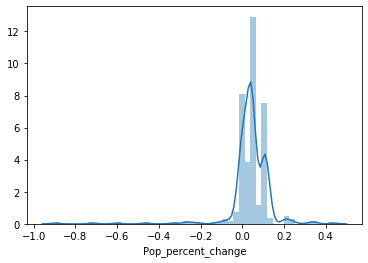

In [7]:
# Looking at the response variable
sns.distplot(analysis_df['Pop_percent_change'])

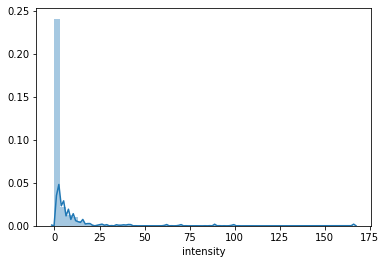

In [6]:
# Looking at Intensity
sns.distplot(analysis_df['intensity'])

### Adding a violent column and a pre/post conflict indicator

In [8]:
# Filtering the treatment to > 1 fatality per 10k and after 2013
analysis_df['violent'] = np.where((analysis_df['intensity'] > 1) & (analysis_df['Year'] >=2014), 1, 0)

In [9]:
# Subsetting the DFs (for plotting)
low_violence_df = analysis_df[analysis_df['violent'] == 0]
high_violence_df = analysis_df[analysis_df['violent'] == 1]

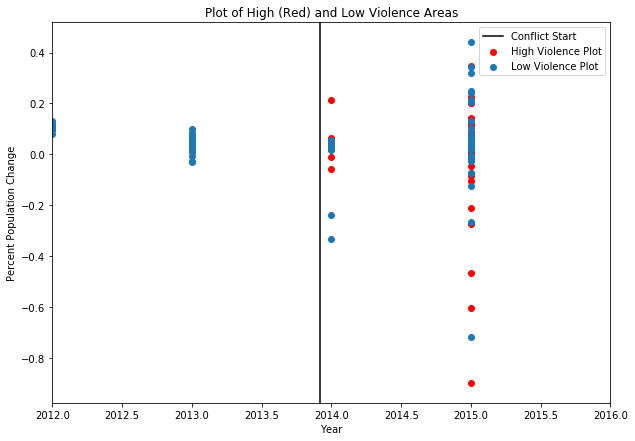

In [10]:
#Sorting the data
high_violence_df_s = high_violence_df.sort_values('Year')
low_violence_df_s = low_violence_df.sort_values('Year')

# Plotting the two dataframes together
plt.figure(figsize=(10,7))
plt.scatter('Year','Pop_percent_change', data = high_violence_df_s, label= 'High Violence Plot', color='red')
plt.scatter('Year', 'Pop_percent_change', label = 'Low Violence Plot', data = low_violence_df_s)
plt.axvline(2013.92, -3.3, 4.5, label='Conflict Start', color = 'black')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percent Population Change')
plt.title('Plot of High (Red) and Low Violence Areas')
plt.xlim(2012,2016)
plt.show()

# Modeling

## Difference and Difference

In [12]:
# Just keeping the violence threshold because of multicolinearity
variables_0 = 'Pop_percent_change ~ C(violent)'
smf.ols(variables_0, data = analysis_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Pop_percent_change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.183
Date:                Wed, 15 Apr 2020   Prob (F-statistic):             0.0133
Time:                        23:14:28   Log-Likelihood:                 362.05
No. Observations:                 405   AIC:                            -720.1
Df Residuals:                     403   BIC:                            -712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0470      0.006      8.471      0.000       0.036       0.058
C(violent)[T.1]    -0.0301      0.012     -2.487      0.013      -0.054      -0.006
==============================================================================
Omnibus:                      381.589   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18052.062
Skew:                          -3.825   Prob(JB):                         0.00
Kurtosis:                      34.800   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# https://www.unifyingdatascience.org/html/interpreting_indicator_vars.html 
# The coefficient is the difference with the other controlls. 

In [15]:
# This was reached after adding a cominbationtion of factors
variables_f = 'Pop_percent_change ~ C(State) + C(violent) + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
smf.ols(variables_f, data = analysis_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Pop_percent_change   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.291
Date:                Wed, 15 Apr 2020   Prob (F-statistic):              0.210
Time:                        23:15:35   Log-Likelihood:                 368.14
No. Observations:                 405   AIC:                            -706.3
Df Residuals:                     390   BIC:                            -646.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0623      0.105      0.592      0.554      -0.145       0.269
C(State)[T.Eastern Equatoria]          -0.0374      0.025     -1.476      0.141      -0.087       0.012
C(State)[T.Jonglei]                    -0.0008      0.024     -0.034      0.973      -0.048       0.046
C(State)[T.Lakes]                      -0.0247      0.026     -0.955      0.340      -0.076       0.026
C(State)[T.Northern Bahr el Ghazal]     0.0069      0.035      0.197      0.844      -0.062       0.075
C(State)[T.Unity]                       0.0136      0.029      0.466      0.641      -0.044       0.071
C(State)[T.Upper Nile]                 -0.0172      0.028     -0.623      0.534      -0.071       0.037
C(State)[T.Warrap]                     -0.0052      0.030     -0.173      0.863      -0.064       0.054
C(State)[T.Western Bahr el Ghazal]     -0.0175      0.033     -0.533      0.594      -0.082       0.047
C(State)[T.Western Equatoria]           0.0052      0.024      0.218      0.827      -0.041       0.052
C(violent)[T.1]                        -0.0341      0.013     -2.694      0.007      -0.059      -0.009
Population_Percent_Child                0.2049      0.079      2.580      0.010       0.049       0.361
Population_Percent_Female              -0.1847      0.218     -0.848      0.397      -0.613       0.243
Poverty_Rate                           -0.0505      0.072     -0.706      0.481      -0.191       0.090
intensity                               0.0002      0.000      0.446      0.656      -0.001       0.001
==============================================================================
Omnibus:                      358.712   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14705.128
Skew:                          -3.509   Prob(JB):                         0.00
Kurtosis:                      31.673   Cond. No.                         633.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
analysis_df.head(1)

,County,State,Year,Population,Pop_percent_change,Fatalities,intensity,Hospitals,estimated_yield,Population_Percent_Child,Population_Percent_Female,Poverty_Rate,Airport,violent
0,Abiemnhom,Unity,2011,19393,0.0,0,0.0,0,15.0,0.5277,0.5003,0.53,0,0


In [19]:
# Adding some interaction terms 
# All the BIC does slightly improve, these added factors have limited explainitory power/are not significant.
variables_f2 = 'Pop_percent_change ~ C(State) + C(violent) + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
smf.ols(variables_f2, data = analysis_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Pop_percent_change   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.377
Date:                Wed, 15 Apr 2020   Prob (F-statistic):              0.167
Time:                        23:21:09   Log-Likelihood:                 368.04
No. Observations:                 405   AIC:                            -708.1
Df Residuals:                     391   BIC:                            -652.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0644      0.105      0.613      0.540      -0.142       0.271
C(State)[T.Eastern Equatoria]          -0.0374      0.025     -1.476      0.141      -0.087       0.012
C(State)[T.Jonglei]                     0.0005      0.024      0.020      0.984      -0.046       0.047
C(State)[T.Lakes]                      -0.0244      0.026     -0.944      0.346      -0.075       0.026
C(State)[T.Northern Bahr el Ghazal]     0.0081      0.035      0.234      0.815      -0.060       0.076
C(State)[T.Unity]                       0.0157      0.029      0.545      0.586      -0.041       0.072
C(State)[T.Upper Nile]                 -0.0176      0.028     -0.639      0.523      -0.072       0.037
C(State)[T.Warrap]                     -0.0043      0.030     -0.145      0.885      -0.063       0.054
C(State)[T.Western Bahr el Ghazal]     -0.0172      0.033     -0.525      0.600      -0.082       0.047
C(State)[T.Western Equatoria]           0.0050      0.024      0.211      0.833      -0.042       0.051
C(violent)[T.1]                        -0.0329      0.012     -2.663      0.008      -0.057      -0.009
Population_Percent_Child                0.2037      0.079      2.570      0.011       0.048       0.360
Population_Percent_Female              -0.1838      0.218     -0.845      0.399      -0.611       0.244
Poverty_Rate                           -0.0547      0.071     -0.771      0.441      -0.194       0.085
==============================================================================
Omnibus:                      358.891   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14726.820
Skew:                          -3.512   Prob(JB):                         0.00
Kurtosis:                      31.695   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Adding some interaction terms 
# All the BIC does slightly improve, these added factors have limited explainitory power/are not significant.
variables_f2 = 'Pop_percent_change ~ C(State) + C(violent) + Population_Percent_Child*C(violent) + Population_Percent_Female + Poverty_Rate'
smf.ols(variables_f2, data = analysis_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Pop_percent_change   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.011
Date:                Wed, 15 Apr 2020   Prob (F-statistic):             0.0161
Time:                        23:24:07   Log-Likelihood:                 373.09
No. Observations:                 405   AIC:                            -716.2
Df Residuals:                     390   BIC:                            -656.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.1480      0.107      1.380      0.168      -0.063       0.359
C(State)[T.Eastern Equatoria]               -0.0278      0.025     -1.104      0.270      -0.077       0.022
C(State)[T.Jonglei]                          0.0093      0.023      0.395      0.693      -0.037       0.055
C(State)[T.Lakes]                           -0.0179      0.026     -0.699      0.485      -0.068       0.032
C(State)[T.Northern Bahr el Ghazal]          0.0220      0.035      0.635      0.526      -0.046       0.090
C(State)[T.Unity]                            0.0244      0.029      0.852      0.395      -0.032       0.081
C(State)[T.Upper Nile]                      -0.0112      0.027     -0.411      0.681      -0.065       0.042
C(State)[T.Warrap]                           0.0042      0.030      0.142      0.887      -0.054       0.062
C(State)[T.Western Bahr el Ghazal]          -0.0096      0.033     -0.295      0.768      -0.074       0.054
C(State)[T.Western Equatoria]                0.0100      0.023      0.428      0.669      -0.036       0.056
C(violent)[T.1]                             -0.2895      0.083     -3.502      0.001      -0.452      -0.127
Population_Percent_Child                     0.0903      0.086      1.046      0.296      -0.079       0.260
Population_Percent_Child:C(violent)[T.1]     0.4776      0.152      3.138      0.002       0.178       0.777
Population_Percent_Female                   -0.2322      0.216     -1.077      0.282      -0.656       0.192
Poverty_Rate                                -0.0663      0.070     -0.944      0.346      -0.204       0.072
==============================================================================
Omnibus:                      322.144   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10146.494
Skew:                          -3.051   Prob(JB):                         0.00
Kurtosis:                      26.749   Cond. No.                         68.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# # All the BIC does slightly improve, these added factors have limited explainitory power/are not significant.
# variables_f2 = 'Pop_percent_change ~ C(State) + C(violent) + C(Airport) + Hospitals + estimated_yield + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_f2, data = analysis_df).fit().summary()

## Pre Post (Conflict Starting in 2014)

In [ ]:
# # Jointplot of intensity vs Population change
# plt.figure(figsize= (6,7))
# sns.jointplot(x='intensity',y='Pop_percent_change',data=analysis_df,kind='reg', color='blue')

In [ ]:
# # Just keeping the violence threshold because of multicolinearity
# variables_2 = 'Pop_percent_change ~ C(State) + C(violent) + C(Airport) + Hospitals + estimated_yield + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_2, data = analysis_df).fit().summary()

# analysis_df.head(1)

# # Just keeping the violence threshold because of multicolinearity
# variables_1 = 'Pop_percent_change ~ C(State) + C(violent) + Hospitals + estimated_yield'
# smf.ols(variables_1, data = analysis_df).fit().summary()

# # # Fitting a OLS Just on The DF with Violence 
# # variables_0 = 'Pop_percent_change ~ intensity'
# # smf.ols(variables_0, data = analysis_df).fit().summary()

# analysis_df['Airport'].unique()

# # Fitting a OLS Just on The DF with Violence and State as a Factor Variable
# # P value for intensity goes down slightly but still not significant. 
# variables_1 = 'Pop_percent_change ~ C(State) + intensity'
# smf.ols(variables_1, data = analysis_df).fit().summary()

# # Fitting a OLS Just on The DF with Violence and State as a Factor Variable
# # Year matters, duh
# variables_2 = 'Pop_percent_change ~ C(State) + C(Year) + intensity'
# smf.ols(variables_2, data = analysis_df).fit().summary()

# # OLS, more factors added
# # Year matters, duh
# variables_3 = 'Pop_percent_change ~ C(State) + C(Year) + Hospitals + Population_Percent_Child + Population_Percent_Female + Poverty_Rate + intensity'
# smf.ols(variables_3, data = analysis_df).fit().summary()

# # OLS, more factors added. Instead of using Intenstiy, just kept violence
# variables_4 = 'Pop_percent_change ~ C(State) + C(Year) + C(violent) + Hospitals + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_4, data = analysis_df).fit().summary()

# # OLS, more factors added. Instead of using Intenstiy, just kept violence
# variables_5 = 'Pop_percent_change ~ C(State) + C(Year) + C(violent) + Hospitals + C(Airport) + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_5, data = analysis_df).fit().summary()

# # OLS, more factors added. Instead of using Intenstiy, just kept violence
# variables_5 = 'Pop_percent_change ~ C(State) + C(Year) + C(violent) + Hospitals + C(Airport) + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_5, data = analysis_df).fit().summary()

# # OLS, more factors added. Instead of using Intenstiy, just kept violence
# variables_5 = 'Pop_percent_change ~ C(State) + C(Year) + C(violent) + Hospitals + C(Airport) + Population_Percent_Child + Population_Percent_Female + Poverty_Rate'
# smf.ols(variables_5, data = analysis_df).fit().summary()

# #Sorting the data
# high_violence_df_s = high_violence_df.sort_values('intensity')
# low_violence_df_s = low_violence_df.sort_values('intensity')

# # Plotting the two dataframes together
# plt.plot('intensity', 'Pop_percent_change', label= 'High Violence Plot (Red)', data = high_violence_df_s, color='red')
# plt.plot('intensity', 'Pop_percent_change', label = 'Low Violence Plot', data = low_violence_df_s)
# plt.legend()
# plt.xlabel('Intensity')
# plt.ylabel('Percent Population Change')
# plt.title('Plot of High and Low Violence Areas')
# plt.xlim((-1, 35))  
# plt.show()
# print('\n')
# print("Cropped for readability, it does show some dips downward with the higher violence areas, but it is hard to say how well an OLS will fit")

# # Plotting the two dataframes together
# plt.plot('intensity', 'Pop_percent_change', label= 'High Violence Plot (Red)', data = high_violence_df_s, color='red')
# plt.plot('intensity', 'Pop_percent_change', label = 'Low Violence Plot', data = low_violence_df_s)
# plt.legend()
# plt.xlabel('Intensity')
# plt.ylabel('Percent Population Change')
# plt.title('Plot of High and Low Violence Areas')
# plt.xlim((-1, 35))  
# plt.show()

# analysis_df_2014_2015['intensity'].describe()
# # Filtering to 2014/15 
# analysis_df_2014_2015 = analysis_df[((analysis_df['Year'] == 2014) | 
#                                     (analysis_df['Year'] == 2014))]

# analysis_df_2014_2015['intensity'].describe()

# # Filtering to 2014/15 
# analysis_df_2014_2015 = analysis_df[((analysis_df['Year'] == 2014) | 
#                                     (analysis_df['Year'] == 2014))]

# analysis_df_2014_2015['intensity'].describe()

# Adding a conflict_start (because the fighting kicked off in Dec 2013)
#analysis_df['conflict_start'] = np.where(analysis_df['Year'] >=2014, 1, 0)